In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import joblib as jb
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SequentialFeatureSelector
from warnings import filterwarnings
filterwarnings('ignore')

# data information

In [3]:
df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71892 entries, 0 to 71891
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             71892 non-null  object 
 1   is_movie_package_subscriber  71892 non-null  object 
 2   subscription_age             71892 non-null  float64
 3   bill_avg                     71892 non-null  int64  
 4   remaining_contract           71892 non-null  float64
 5   service_failure_count        71892 non-null  int64  
 6   download_avg                 71892 non-null  float64
 7   upload_avg                   71892 non-null  float64
 8   download_over_limit          71892 non-null  int64  
 9   churn                        71892 non-null  int64  
 10  has_contract                 71892 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 6.0+ MB


### Preprocessing

In [4]:
# checking nans
df.isna().sum()

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
has_contract                   0
dtype: int64

In [5]:
# Checking duplicates
df.duplicated().sum()

1953

In [6]:
# Droping Duplicates and reset data frame index 
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
# seeing numerical distribution to determine if we need to scale or not
df.describe()  

,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,has_contract
count,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000,69939.000000
mean,2.484932,19.262886,0.511325,0.282775,44.909511,4.309144,0.208024,0.544703,0.707831
std,2.037541,13.182590,0.669639,0.828192,63.858322,9.929755,0.997785,0.498001,0.454763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.950000,13.000000,0.000000,0.000000,8.200000,0.600000,0.000000,0.000000,0.000000
50%,1.980000,19.000000,0.000000,0.000000,29.100000,2.200000,0.000000,1.000000,1.000000
75%,3.370000,23.000000,1.050000,0.000000,61.800000,5.000000,0.000000,1.000000,1.000000
max,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000,1.000000


- according to this wide variety in data scales we will apend a scaler in our pipline to scale before fiting 

In [8]:
# looking for object columns to see how to deal with them 
df.is_movie_package_subscriber.unique()

array(['no', 'yes'], dtype=object)

In [9]:
df.is_tv_subscriber.unique()

array(['yes', 'no'], dtype=object)

In [10]:
# Creating function that labelencoding those two features
def enc(x):
    return 1 if x == 'yes' else 0 

In [11]:
# Encoding categorical features
df['is_movie_package_subscriber'] = df['is_movie_package_subscriber'].apply(enc)
df['is_tv_subscriber'] = df['is_tv_subscriber'].apply(enc)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69939 entries, 0 to 69938
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             69939 non-null  int64  
 1   is_movie_package_subscriber  69939 non-null  int64  
 2   subscription_age             69939 non-null  float64
 3   bill_avg                     69939 non-null  int64  
 4   remaining_contract           69939 non-null  float64
 5   service_failure_count        69939 non-null  int64  
 6   download_avg                 69939 non-null  float64
 7   upload_avg                   69939 non-null  float64
 8   download_over_limit          69939 non-null  int64  
 9   churn                        69939 non-null  int64  
 10  has_contract                 69939 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.9 MB


In [13]:
x = df.drop('churn',axis=1)
y = df['churn']

## Modeling and pipeline

In [253]:
models = [('logistic', LogisticRegression()), ('svc', SVC())]
naive_models = [('bernoulli', BernoulliNB()), ('Multinominal', MultinomialNB()), ('Gaussian', GaussianNB())]
tree_based = [('Decisiontree', DecisionTreeClassifier()), ('Randomforest', RandomForestClassifier(n_estimators=30)),
              ('Adaboost', AdaBoostClassifier()), ('xgboost', XGBClassifier(n_estimators=50))]

In [17]:
# Testing svm and logistic models
for model in models:
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(model)
    pipe = Pipeline(steps=steps)
    scores = cross_validate(pipe,x, y, cv=5,  return_train_score=True, scoring='accuracy')
    print(f"train accuracy of  {model[0]} is: {scores['train_score'].mean()}" )
    print(f"test accuracy of  {model[0]} is: {scores['test_score'].mean()}" )
    print('*' * 80)
    print('\n')

train accuracy of  logistic is: 0.8762027448600842
test accuracy of  logistic is: 0.8570750896820138
********************************************************************************


train accuracy of  svc is: 0.8952550576636906
test accuracy of  svc is: 0.8362855187296656
********************************************************************************




In [254]:
# Testing naive models
for model in naive_models:
    steps = list()
    steps = steps[:1]
    steps.append(model)
    pipe = Pipeline(steps=steps)
    scores = cross_validate(pipe,x, y, cv=5,  return_train_score=True, scoring='accuracy')
    print(f"train accuracy of {model[0]} is: {scores['train_score'].mean()}" )
    print(f"test accuracy of  {model[0]} is: {scores['test_score'].mean()}" )
    print('*' * 80)
    print('\n')

train accuracy of bernoulli is: 0.922879187670784
test accuracy of  bernoulli is: 0.9115923802279002
********************************************************************************


train accuracy of Multinominal is: 0.7275695998797347
test accuracy of  Multinominal is: 0.7151783881020775
********************************************************************************


train accuracy of Gaussian is: 0.819370991155416
test accuracy of  Gaussian is: 0.8268044284104736
********************************************************************************




In [255]:
# Testing tree_based models
for model in tree_based:
    steps = list()
    steps = steps[:1]
    steps.append(model)
    pipe = Pipeline(steps=steps)
    scores = cross_validate(pipe,x, y, cv=5,  return_train_score=True, scoring='accuracy')
    print(f"train accuracy of {model[0]} is: {scores['train_score'].mean()}" )
    print(f"test accuracy of  {model[0]} is: {scores['test_score'].mean()}" )
    print('*' * 80)
    print('\n')

train accuracy of Decisiontree is: 0.9999857018386533
test accuracy of  Decisiontree is: 0.5035665936294985
********************************************************************************


train accuracy of Randomforest is: 0.9990134252060405
test accuracy of  Randomforest is: 0.5915328909832303
********************************************************************************


train accuracy of Adaboost is: 0.9403729902825069
test accuracy of  Adaboost is: 0.517078044139152
********************************************************************************


train accuracy of xgboost is: 0.9553467549736764
test accuracy of  xgboost is: 0.5322066443943955
********************************************************************************




### tuning and selecting best features for (DecisionTreeClassifier, RandomForestClassifier, BernoulliNB)

#### DecisionTree Tuning 

In [49]:
# pramaters for tuning Decision tree
parameters={'criterion':['gini','entropy'],
            "splitter":["best","random"],
            "max_depth" : [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            'min_samples_split': [2, 5, 10],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
           }

In [50]:
# Model Tuning
# tun = RandomizedSearchCV(DecisionTreeClassifier(), parameters, cv=3, return_train_score=True, scoring='accuracy', n_iter = 100, verbose=2,n_jobs=-1)

In [51]:
# tun.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 15, 20, 30, 40, 50,
                                                      70, 90, 120, 150],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6,
                                                                     0.7, 0.8,
                                                                     0.9],
                                        'splitter': ['best', 'random']},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [54]:
# Best Model For fitting this data
#tun.best_estimator_

In [53]:
tun.best_score_

0.9176854115729421

In [55]:
decision_model = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=30,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.1)

In [56]:
# Creating Object Of forward elimination Feature Selector
feature_selector = SequentialFeatureSelector(estimator=decision_model, n_features_to_select='auto', scoring='accuracy', direction='forward')

In [57]:
# Fitting to choose best features for our model
feature_selector.fit(x,y)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=4,
                                                           max_leaf_nodes=30,
                                                           min_samples_leaf=8,
                                                           min_samples_split=5,
                                                           min_weight_fraction_leaf=0.1),
                          n_features_to_select='auto', scoring='accuracy')

In [58]:
# Saving only important feature for decisiontree model in new data frame 
decision_x = pd.DataFrame(feature_selector.transform(x), columns=feature_selector.get_feature_names_out())

In [286]:
decision_scores = cross_validate(decision_model, decision_x,y, cv = 5, return_train_score=True, scoring='accuracy' )
print(f"DecisionTree Test Score Average: {decision_scores['train_score'].mean()} ")
print(f"DecisionTree train Score Average: {decision_scores['test_score'].mean()} ")

DecisionTree Test Score Average: 0.9176352972756959 
DecisionTree train Score Average: 0.9159256330978852 


In [59]:
# Spliting the data into train and test and fit the best model we got with x_train and y_train
decision_x_train, decision_x_test, decision_y_train, decision_y_test = train_test_split(decision_x, y, stratify=y, random_state=4, test_size=0.2)
decision_model.fit(decision_x_train, decision_y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=30,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.1)

In [288]:
# predict on x_test and x_train to evaluate
decision_y_hat = decision_model.predict(decision_x_test)
decision_y_trained_hat = decision_model.predict(decision_x_train)

# printing the accuracies metrics on predicted and true values
print(f"DecisionTree Train Score Average: {accuracy_score(decision_y_train, decision_y_trained_hat)} ")
print(f"DecisionTree Test Score Average: {accuracy_score(decision_y_test, decision_y_hat)} ")
print(f"DecisionTree Recall Score Average: {recall_score(decision_y_test,decision_y_hat)} ")
print(f"DecisionTree percision Score Average: {precision_score(decision_y_test, decision_y_hat)} ")

DecisionTree Train Score Average: 0.9176779682221944 
DecisionTree Test Score Average: 0.917715184443809 
DecisionTree Recall Score Average: 0.9047119044494029 
DecisionTree percision Score Average: 0.9419240229570921 


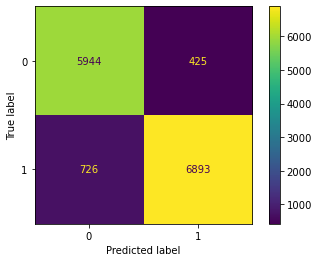

In [289]:
plot_confusion_matrix(decision_tree_model, decision_x_test, decision_y_test)

#### RandomForest Tuning

In [323]:
#Random Forest Tuning
random_grid= {
                'bootstrap': [True, False],
                'criterion':['gini','entropy'],
                'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
                'max_features': ["auto","log2","sqrt",None],
                "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
                'min_samples_split': [2, 5, 10],
                'n_estimators': list(range(30, 500, 20)),
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [60]:
# rf_random.fit(x,y)

In [61]:
# rf_random.best_estimator_

In [331]:
rf_random.best_score_

0.9269363302306295

In [62]:
rand_model = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=120,
                       max_leaf_nodes=10, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.1,
                       n_estimators=190)

In [63]:
# Intializing forward feature selector to select the best features in the data that fits well on randoforest
rand_selector = SequentialFeatureSelector(estimator=rand_model, direction='forward', n_features_to_select='auto', scoring='accuracy')

In [64]:
rand_selector.fit(x,y)

SequentialFeatureSelector(estimator=RandomForestClassifier(bootstrap=False,
                                                           criterion='entropy',
                                                           max_depth=120,
                                                           max_leaf_nodes=10,
                                                           min_samples_leaf=3,
                                                           min_samples_split=5,
                                                           min_weight_fraction_leaf=0.1,
                                                           n_estimators=190),
                          n_features_to_select='auto', scoring='accuracy')

In [65]:
# Getting the features that selected
rand_x = pd.DataFrame(rand_selector.transform(x), columns=rand_selector.get_feature_names_out())

In [66]:
# Spliting the data into train and test and fit the best model we got with x_train and y_train
rand_x_train, rand_x_test, rand_y_train, rand_y_test = train_test_split(rand_x, y, test_size=0.2, random_state=4, stratify=y)
rand_model.fit(rand_x_train, rand_y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=120,
                       max_leaf_nodes=10, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.1,
                       n_estimators=190)

In [337]:
# pridect on train and test values to evaluate the model
rand_y_hat = rand_model.predict(rand_x_test)
rand_y_train_hat = rand_model.predict(rand_x_train)


# printing the accuracies metrics on predicted and true values
print(f"RandomForest Test Score Average: {accuracy_score(rand_y_test, rand_y_hat)} ")
print(f"RandomForest Train Score Average: {accuracy_score(rand_y_train, rand_y_train_hat)} ")
print(f"RandomForest Recall Score Average: {recall_score(rand_y_test,rand_y_hat)} ")
print(f"RandomForest percision Score Average: {precision_score(rand_y_test, rand_y_hat)} ")

RandomForest Test Score Average: 0.9328710323134115 
RandomForest Train Score Average: 0.9334060159782667 
RandomForest Recall Score Average: 0.9288620553878462 
RandomForest percision Score Average: 0.9468825260904469 


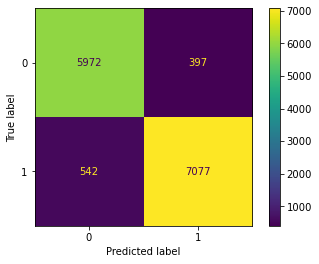

In [338]:
plot_confusion_matrix(rand_model, rand_x_test, rand_y_test)

#### BernoulliNB Tuning

In [67]:
# Model Initialization
ber_model = BernoulliNB()

In [68]:
# Intializing forward feature selector to select the best features in the data that fits well on BernoulliNB
berno_selection = SequentialFeatureSelector(estimator=ber_model, n_features_to_select='auto', scoring='accuracy', direction='forward')

In [69]:
berno_selection.fit(x,y)

SequentialFeatureSelector(estimator=BernoulliNB(), n_features_to_select='auto',
                          scoring='accuracy')

In [70]:
# Getting the features that selected in new data frame
ber_x = pd.DataFrame(berno_selection.transform(x), columns=berno_selection.get_feature_names_out())

In [71]:
# Spliting the data into train and test and fit the best model we got with x_train and y_train
ber_x_train, ber_x_test, ber_y_train, ber_y_test = train_test_split(ber_x, y , test_size=0.2, random_state=4, stratify=y)
ber_model.fit(ber_x_train, ber_y_train)

BernoulliNB()

In [72]:
# pridect on train and test values to evaluate the model
ber_y_hat = ber_model.predict(ber_x_test)
ber_y_train_hat = ber_model.predict(ber_x_train)

# printing the accuracies metrics on predicted and true values
print(f"BernoulliNB Test Score Average: {accuracy_score(ber_y_test, ber_y_hat)} ")
print(f"BernoulliNB Train Score Average: {accuracy_score(ber_y_train, ber_y_train_hat)} ")
print(f"BernoulliNB Recall Score Average: {recall_score(ber_y_test,ber_y_hat)} ")
print(f"BernoulliNB percision Score Average: {precision_score(ber_y_test, ber_y_hat)} ")

BernoulliNB Test Score Average: 0.9330140120102945 
BernoulliNB Train Score Average: 0.9335489982305947 
BernoulliNB Recall Score Average: 0.9285995537472109 
BernoulliNB percision Score Average: 0.9473754686663096 


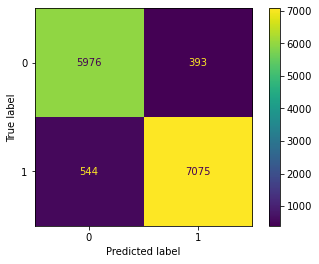

In [73]:
plot_confusion_matrix(ber_model, ber_x_test, ber_y_test)

### According to the accuracy, Recall and precision the best model is Bernoulli Naive baye model so we will train it on the whole data set contains only features selected for it

In [74]:
# Model Initialization
ber_model = BernoulliNB()
ber_model.fit(ber_x, y)

BernoulliNB()

In [22]:
# jb.dump(ber_model, 'BernoulliNBmodel.h5')
# jb.dump(ber_x.columns, 'featuresnames.h5')

['featuresnames.h5']